# Gesture Recognition


### **Problem Statement**
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

Gesture	Corresponding Action
Thumbs Up	Increase the volume.
Thumbs Down	Decrease the volume.
Left Swipe	'Jump' backwards 10 seconds.
Right Swipe	'Jump' forward 10 seconds.
Stop	Pause the movie.
Each video is a sequence of 30 frames (or images).

### **Objectives**
1. Generator: The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. Model: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. Write up: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 8 #experiment with the batch size

### **Data Generator**
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [335]:
# Parameters
total_frames = 30
num_frames = 15
gestures = 5
image_height = 100
image_width = 100
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int) #create a list of image numbers you want to use for a particular video

In [336]:
from skimage.io import imread
from skimage.transform import resize

def resize_crop_image(image):
    if image.shape[0] > 120 and image.shape[1] > 120:
        image = resize(image, (120, 120))
        
    height = image.shape[0]
    width = image.shape[1]
    height_center = height//2
    width_center = width//2
    image = image[(height_center-60):(height_center+70), (width_center-50):(width_center+70)]
    image = resize(image,(image_height, image_width))
    return image

Let's test the function `resize_crop_image` by writing a test function

In [337]:
from matplotlib import pyplot as plt

def show_resize_crop_image(paths):

    for index, path in enumerate(paths):
        plt.figure(figsize=(20,20))
            
        plt.subplot(5, 2, index*2+1)
        image = resize_crop_image(imread(path))
        plt.imshow(image)
        plt.title('Modified')
        
        plt.subplot(5, 2, index*2+2)
        plt.imshow(imread(path))
        plt.title('Original')
                
    plt.show()

Calling the test function

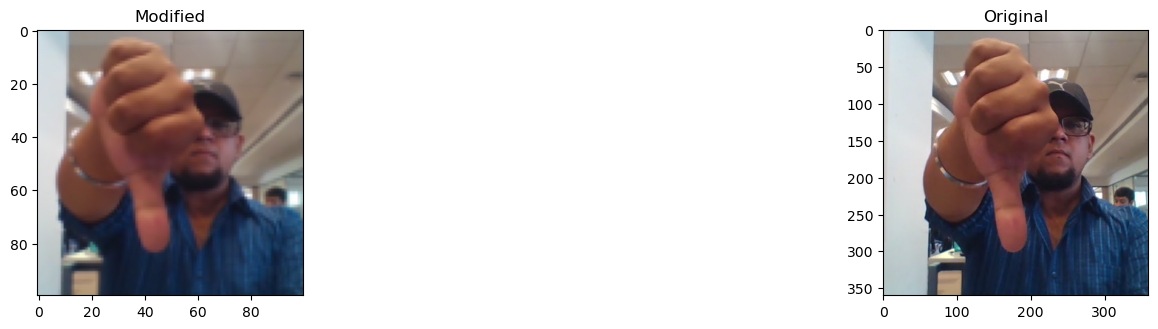

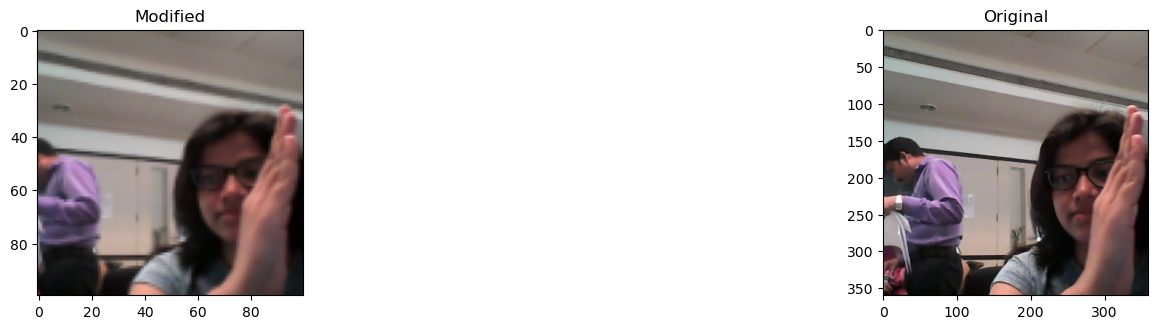

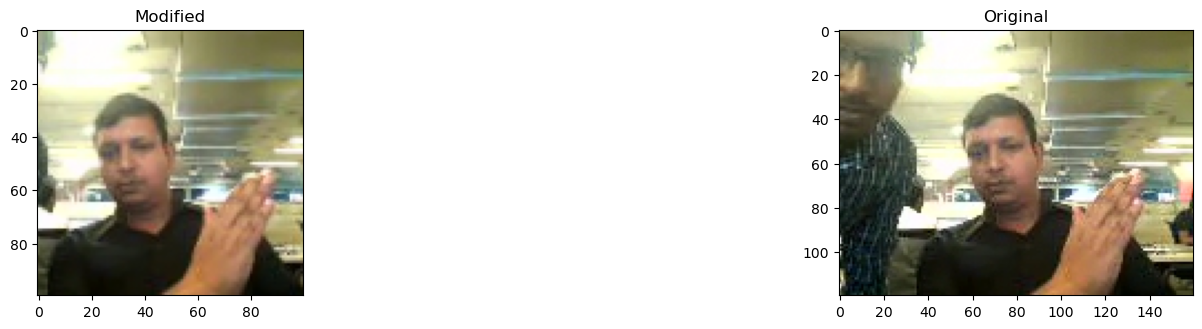

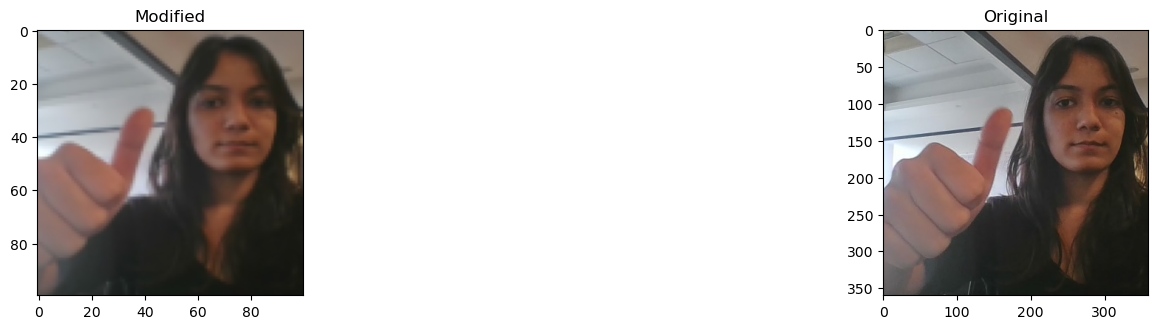

In [235]:
paths = ["Project_data/train/WIN_20180907_15_45_56_Pro_Thumbs Down_new/WIN_20180907_15_45_56_Pro_00040.png",
        "Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00026.png",
        "Project_data/train/WIN_20180925_17_22_32_Pro_Right_Swipe_new/WIN_20180925_17_22_32_Pro_00009.png",
        "Project_data/train/WIN_20180907_15_53_12_Pro_Thumbs Up_new/WIN_20180907_15_53_12_Pro_00011.png"]

show_resize_crop_image(paths)

In [9]:
# Define the generator function
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_crop_image(image)
                                         
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            
            for batch in range(batch_size): # we iterate over the number of batches
                batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        image = resize_crop_image(image)
                                         
                        batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            

In [338]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


## **Model**
- Use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. 
- You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax.
- Transfer Learning is part of this project. Experiment with transfer learning as well. 
- Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## **CNN 3D Architecture**

In [310]:
# Importing the required tensorflow libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, TimeDistributed, LSTM, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#### **Experiment 1**


##### **Model 1**
- 3D Convolutional Model
- 3D Convolutional Model with 3 layers of Conv3D and 3 layers of MaxPooling3D
- 2 Dense layers
- 2 Dropout layers
- 2 Batch Normalization layers
- 25 epochs

In [339]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [340]:
optimiser = optimizers.SGD(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_51 (Conv3D)          (None, 15, 100, 100, 8)   656       
                                                                 
 batch_normalization_212 (B  (None, 15, 100, 100, 8)   32        
 atchNormalization)                                              
                                                                 
 activation_212 (Activation  (None, 15, 100, 100, 8)   0         
 )                                                               
                                                                 
 max_pooling3d_51 (MaxPooli  (None, 7, 50, 50, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_52 (Conv3D)          (None, 7, 50, 50, 16)     3472      
                                                     

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [341]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [342]:
model_name = 'model_init_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [343]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [344]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot training & validation accuracy values

Source path =  Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.7361 - categorical_accuracy: 0.1976Source path =  Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.58065, saving model to model_init_2024-02-0720_04_23.449938\model-00001-1.73607-0.19759-1.58065-0.24000.h5


c:\Users\kriss\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


166/166 [==============================] - 165s 996ms/step - loss: 1.7361 - categorical_accuracy: 0.1976 - val_loss: 1.5807 - val_categorical_accuracy: 0.2400 - lr: 0.0100
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.6238 - categorical_accuracy: 0.1968
Epoch 2: val_loss did not improve from 1.58065
166/166 [==============================] - 138s 833ms/step - loss: 1.6238 - categorical_accuracy: 0.1968 - val_loss: 1.6057 - val_categorical_accuracy: 0.2800 - lr: 0.0100
Epoch 3/25
166/166 [==============================] - ETA: 0s - loss: 1.6073 - categorical_accuracy: 0.2028
Epoch 3: val_loss improved from 1.58065 to 1.57080, saving model to model_init_2024-02-0720_04_23.449938\model-00003-1.60726-0.20281-1.57080-0.26000.h5
166/166 [==============================] - 154s 931ms/step - loss: 1.6073 - categorical_accuracy: 0.2028 - val_loss: 1.5708 - val_categorical_accuracy: 0.2600 - lr: 0.0100
Epoch 4/25
166/166 [==============================] - ETA: 0s - loss:

**Training Accuracy:** 0.41%

**Validation Accuracy:** 0.59%

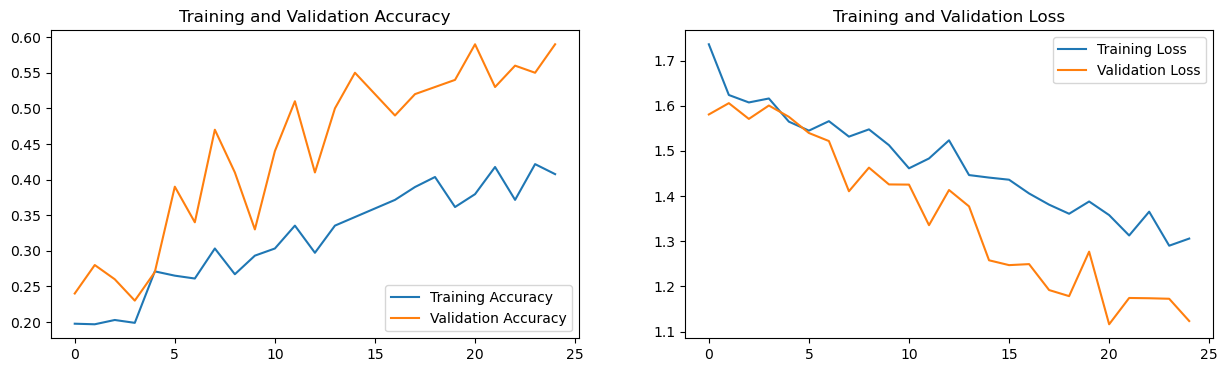

In [345]:
from IPython.display import Markdown, display

def plot_history(history):
    display(Markdown("**Training Accuracy:** " + str(round(history.history['categorical_accuracy'][num_epochs-1], 2)) + "%"))
    display(Markdown("**Validation Accuracy:** " + str(round(history.history['val_categorical_accuracy'][num_epochs-1], 2)) + "%"))
    
    #print("Training Accuracy:" + history.history['categorical_accuracy'][num_epochs-1])
    #print("Validation Accuracy:" + history.history['val_categorical_accuracy'][num_epochs-1])

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)

- From the graph we can see that the model is performing better on the validation data than on the training data. 
- This indicates that the model is too simple and has lesser that required training parameters
- The model is underfitting with the current parameters
- The model has a very low training accuracy and better validation accuracy

#### **Experiment 2**

Reducing the size of the image from 100 to 50

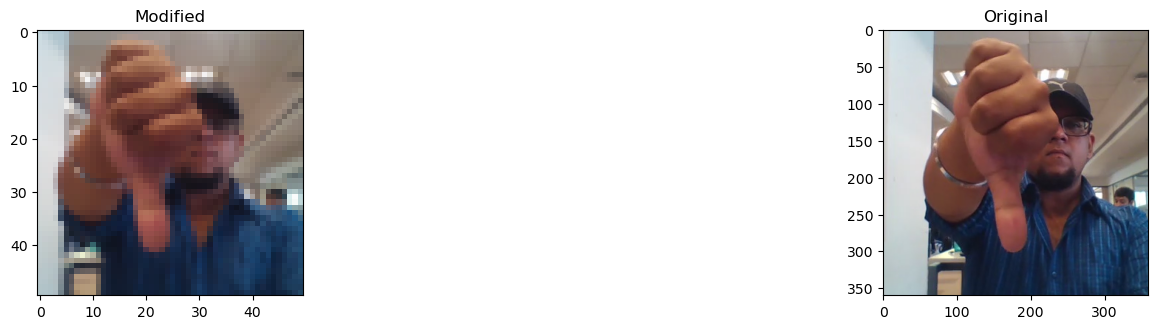

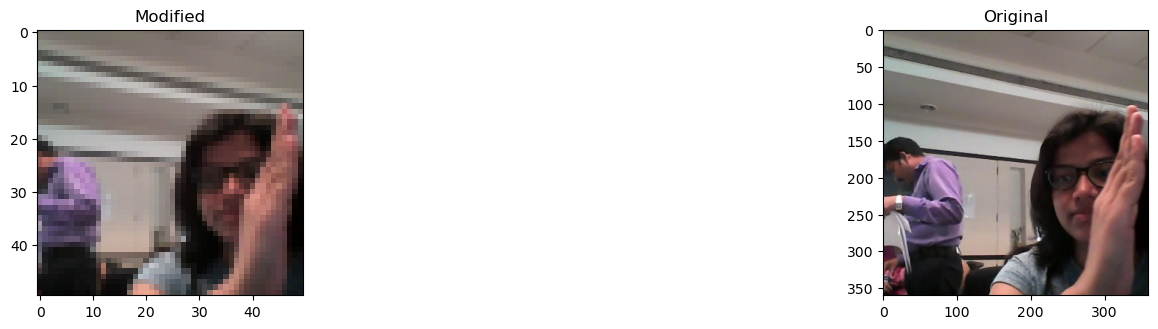

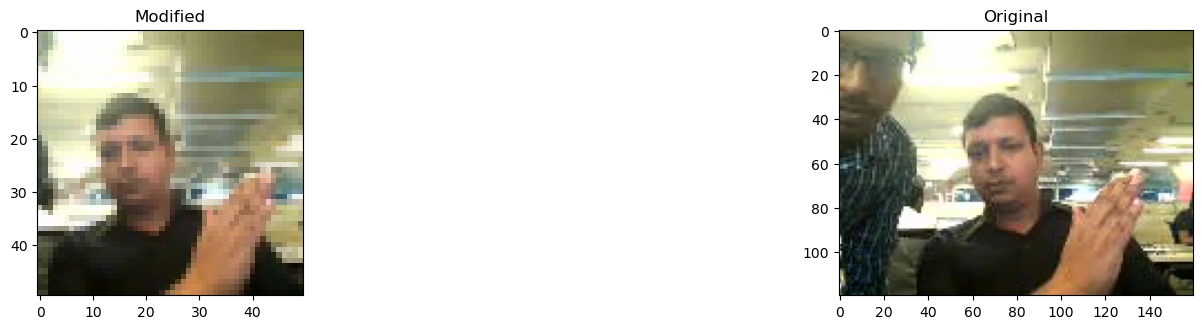

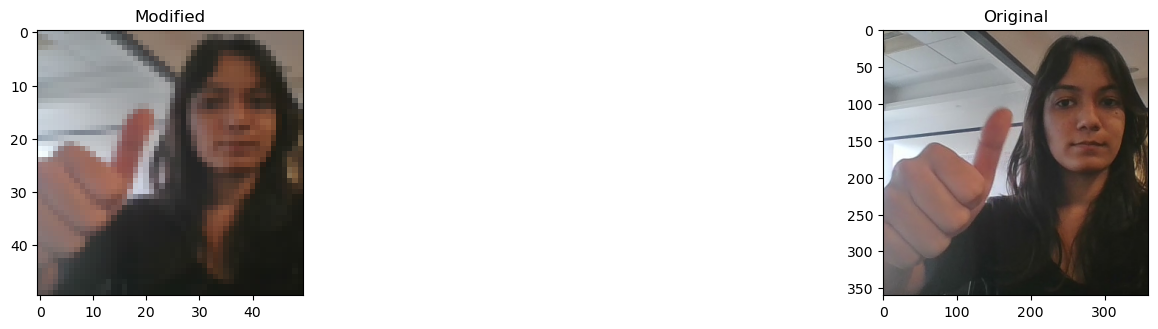

In [236]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=25

show_resize_crop_image(paths)

##### **Model 2**
- 3D Convolutional Model with 3 layers of Conv3D and 3 layers of MaxPooling3D
- 2 Dense layers
- 2 Dropout layers
- 3 Batch Normalization layers
- 25 epochs
- Image size reduced to 50

In [80]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

Compiling the model and printing the summary of the model

In [81]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_24 (Ba  (None, 15, 50, 50, 8)     32        
 tchNormalization)                                               
                                                                 
 activation_24 (Activation)  (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_24 (MaxPooli  (None, 7, 25, 25, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_25 (Conv3D)          (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_25 (Ba  (None, 7, 25, 25, 16)    

Creating the generators

In [82]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [83]:
model_name = 'model_exp2_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [84]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Fit the model and save the model parameters

In [85]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.8155 - categorical_accuracy: 0.2383Source path =  Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.55997, saving model to model_exp2_2024-02-0416_15_07.409691\model-00001-1.81553-0.23831-1.55997-0.24000.h5
166/166 [==============================] - 155s 929ms/step - loss: 1.8155 - categorical_accuracy: 0.2383 - val_loss: 1.5600 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.6075 - categorical_accuracy: 0.2149
Epoch 2: val_loss did not improve from 1.55997
166/166 [==============================] - 132s 802ms/step - loss: 1.6075 - categorical_accuracy: 0.2149 - val_loss: 1.5823 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/25
166/166 [==============================] - ETA: 0s - loss: 1.6058 - categorical_accuracy: 0.2209
Epoch 3: val_loss improved from 1.559

Evaluate the performance of this model

**Training Accuracy:** 0.48%

**Validation Accuracy:** 0.67%

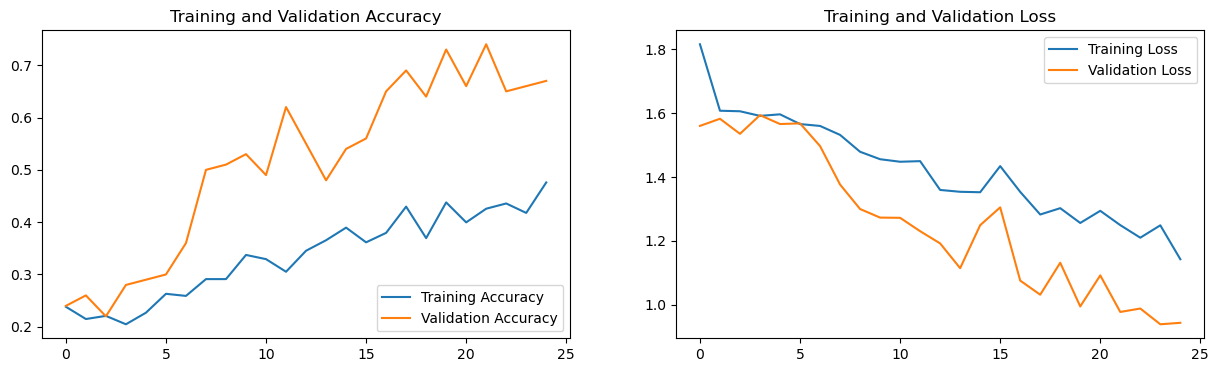

In [86]:
plot_history(history)

<b>Conclusion:</b> 
- Scaling to smaller images not much of difference in the performance of the model.
- The model is underfitting with the current parameters
- The model has a very low training accuracy and better validation accuracy

#### **Experiment 3**

Reducing the size of the image from 50 to 25

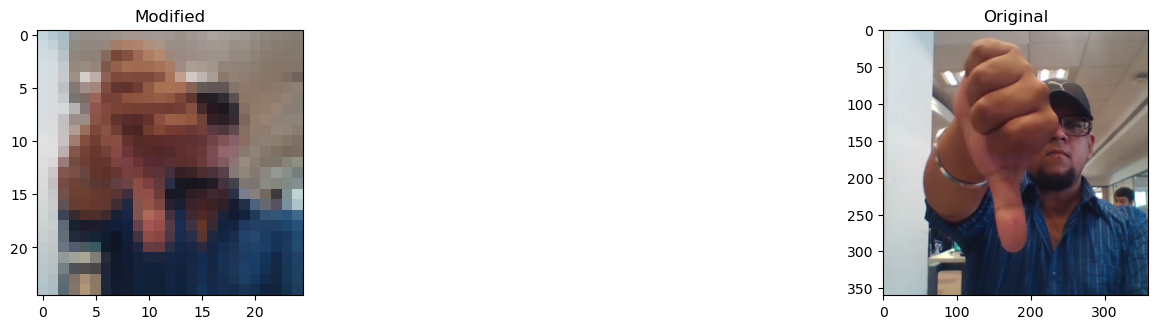

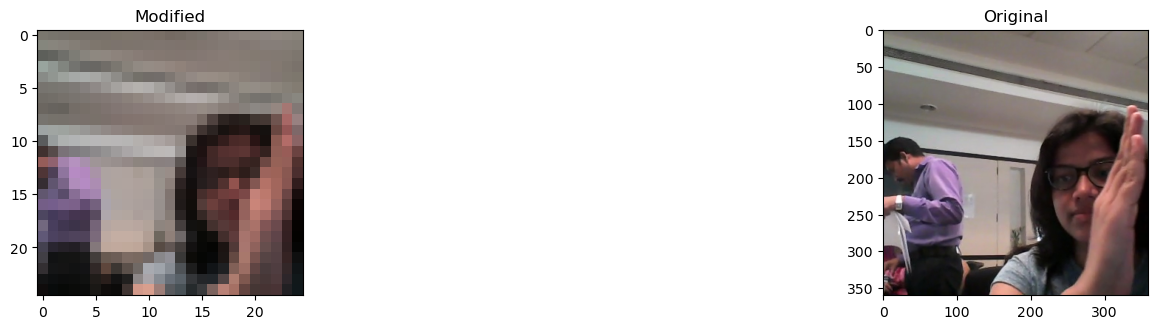

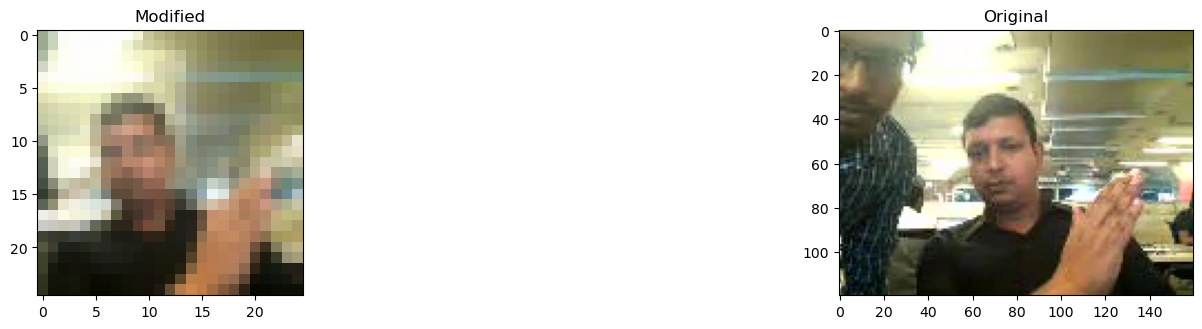

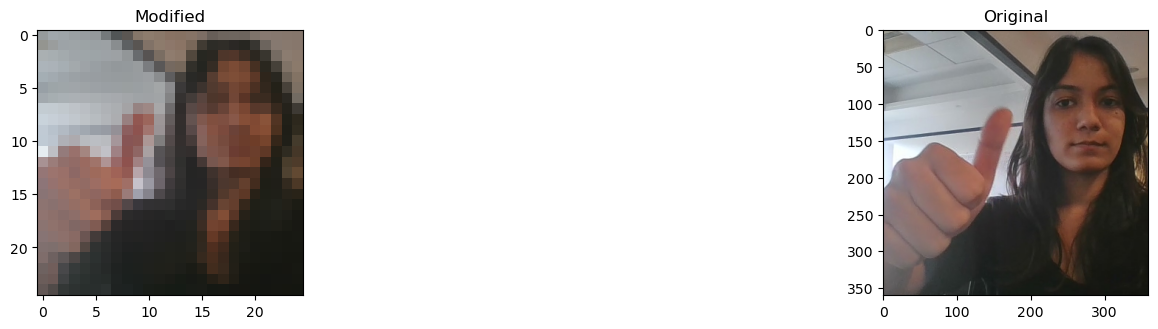

In [240]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 25
image_width = 25
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=25

show_resize_crop_image(paths)

##### **Model 3**
- 3D Convolutional Model with 3 layers of Conv3D and 3 layers of MaxPooling3D
- 2 Dense layers
- 2 Dropout layers
- 3 Batch Normalization layers
- 25 epochs

In [88]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

Compiling the model and printing the summary of the model

In [89]:
optimiser = optimizers.SGD(lr=0.001, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_27 (Conv3D)          (None, 15, 25, 25, 8)     656       
                                                                 
 batch_normalization_27 (Ba  (None, 15, 25, 25, 8)     32        
 tchNormalization)                                               
                                                                 
 activation_27 (Activation)  (None, 15, 25, 25, 8)     0         
                                                                 
 max_pooling3d_27 (MaxPooli  (None, 7, 12, 12, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_28 (Conv3D)          (None, 7, 12, 12, 16)     3472      
                                                                 
 batch_normalization_28 (Ba  (None, 7, 12, 12, 16)    

Creating the generators

In [90]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [91]:
model_name = 'model_exp3_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [92]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Fit the model and save the model parameters

In [93]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.6969 - categorical_accuracy: 0.1916Source path =  Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.59795, saving model to model_exp3_2024-02-0416_15_07.409691\model-00001-1.69692-0.19155-1.59795-0.25000.h5
166/166 [==============================] - 93s 559ms/step - loss: 1.6969 - categorical_accuracy: 0.1916 - val_loss: 1.5980 - val_categorical_accuracy: 0.2500 - lr: 0.0100
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.6271 - categorical_accuracy: 0.1968
Epoch 2: val_loss did not improve from 1.59795
166/166 [==============================] - 80s 482ms/step - loss: 1.6271 - categorical_accuracy: 0.1968 - val_loss: 1.6017 - val_categorical_accuracy: 0.2400 - lr: 0.0100
Epoch 3/25
166/166 [==============================] - ETA: 0s - loss: 1.6003 - categorical_accuracy: 0.2390
Epoch 3: val_loss did not improve from 

Evaluate the performance of this model

**Training Accuracy:** 0.42%

**Validation Accuracy:** 0.49%

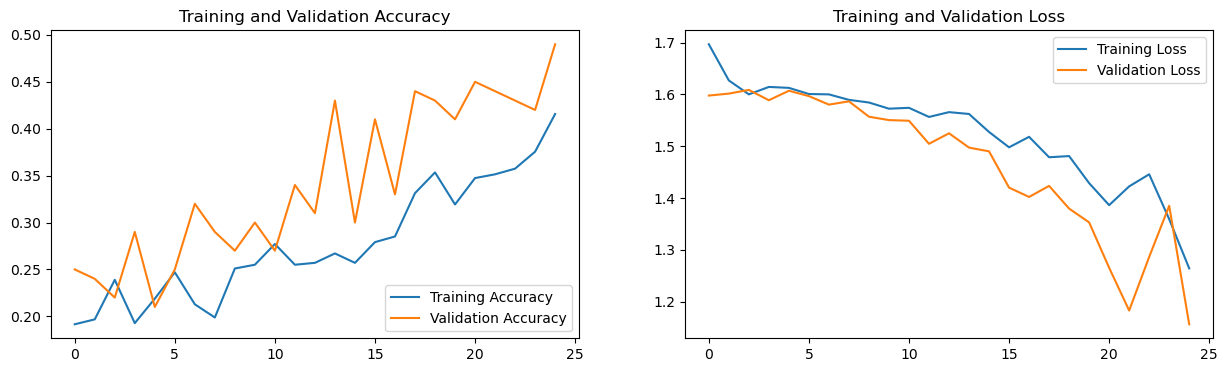

In [94]:
plot_history(history)

<b>Conclusion:</b> 
- Scaling from 50 to 25 reduced the training and validation accuracy
- The model is underfitting with the current parameters
- The model has a very low training accuracy and validation accuracy

#### **Experiment 4**

Decreasing the batch size from 8 to 4

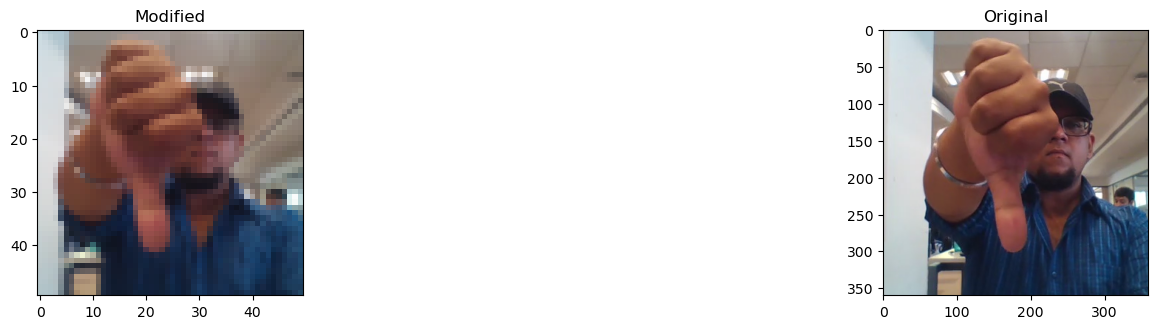

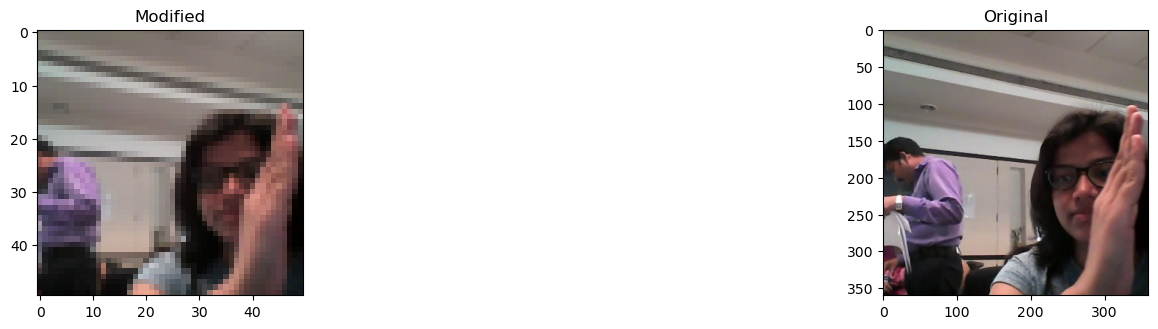

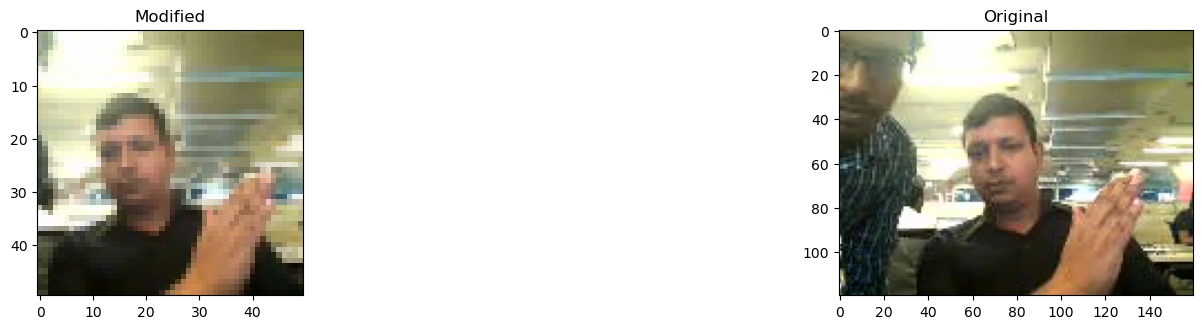

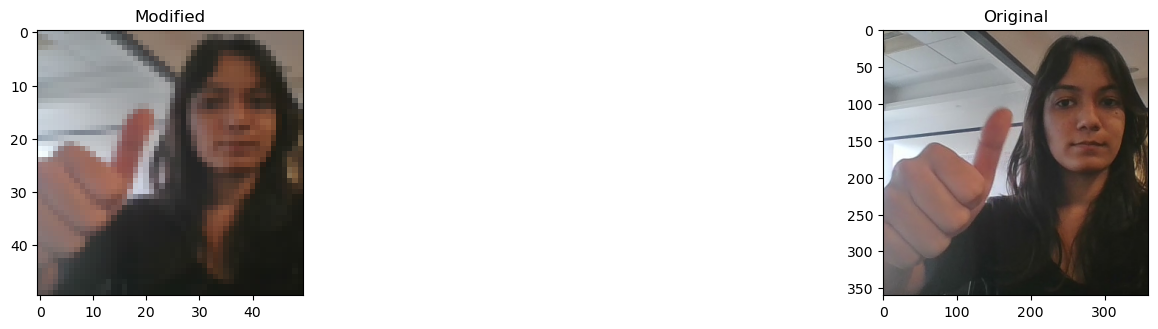

In [239]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
batch_size = 4
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=25

show_resize_crop_image(paths)

##### **Model 4**
- 3D Convolutional Model with 3 layers of Conv3D and 3 layers of MaxPooling3D
- 2 Dense layers
- 2 Dropout layers
- 3 Batch Normalization layers
- 25 epochs
- Batch size reduced to 4

In [96]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

Compiling the model and printing the summary of the model

In [97]:
optimiser = optimizers.SGD(lr=0.001, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_30 (Conv3D)          (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_30 (Ba  (None, 15, 50, 50, 8)     32        
 tchNormalization)                                               
                                                                 
 activation_30 (Activation)  (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_30 (MaxPooli  (None, 7, 25, 25, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_31 (Conv3D)          (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_31 (Ba  (None, 7, 25, 25, 16)   

Creating the generators

In [98]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [99]:
model_name = 'model_exp4_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [100]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Fit the model and save the model parameters

In [101]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.8314 - categorical_accuracy: 0.1750Source path =  Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.62191, saving model to model_exp4_2024-02-0416_15_07.409691\model-00001-1.83136-0.17496-1.62191-0.17000.h5
166/166 [==============================] - 65s 387ms/step - loss: 1.8314 - categorical_accuracy: 0.1750 - val_loss: 1.6219 - val_categorical_accuracy: 0.1700 - lr: 0.0100
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.6133 - categorical_accuracy: 0.2108
Epoch 2: val_loss improved from 1.62191 to 1.60038, saving model to model_exp4_2024-02-0416_15_07.409691\model-00002-1.61331-0.21084-1.60038-0.23000.h5
166/166 [==============================] - 44s 269ms/step - loss: 1.6133 - categorical_accuracy: 0.2108 - val_loss: 1.6004 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 3/25
166/166 [======================

Evaluate the performance of this model

**Training Accuracy:** 0.71%

**Validation Accuracy:** 0.79%

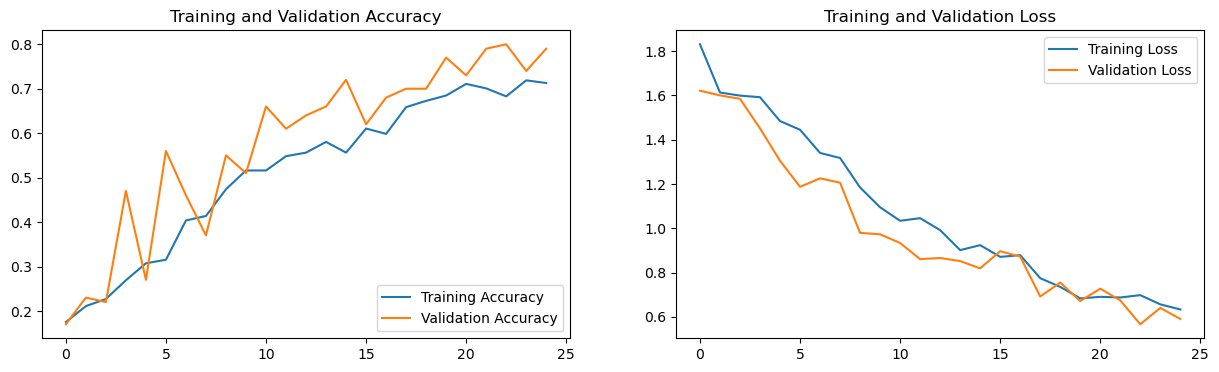

In [102]:
plot_history(history)

<b>Conclusion:</b> 
- Reducing the batch size has reduced overfitting
- Model has resulted in better training and validation accuracy
- Accuracy has improved from the previous models
- The model is underfitting with the current parameters

#### **Experiment 5**

Changing the optmizer from `SGD` to `Adam`

In [103]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
batch_size = 4
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
num_epochs=25

img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

In [104]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_33 (Conv3D)          (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_33 (Ba  (None, 15, 50, 50, 8)     32        
 tchNormalization)                                               
                                                                 
 activation_33 (Activation)  (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_33 (MaxPooli  (None, 7, 25, 25, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_34 (Conv3D)          (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_34 (Ba  (None, 7, 25, 25, 16)   

In [105]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [106]:
model_name = 'model_exp5_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [107]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [108]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.7255 - categorical_accuracy: 0.2172Source path =  Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.58263, saving model to model_exp5_2024-02-0416_15_07.409691\model-00001-1.72553-0.21719-1.58263-0.23000.h5
166/166 [==============================] - 69s 403ms/step - loss: 1.7255 - categorical_accuracy: 0.2172 - val_loss: 1.5826 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.6061 - categorical_accuracy: 0.2369
Epoch 2: val_loss did not improve from 1.58263
166/166 [==============================] - 53s 320ms/step - loss: 1.6061 - categorical_accuracy: 0.2369 - val_loss: 1.6117 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/25
166/166 [==============================] - ETA: 0s - loss: 1.6127 - categorical_accuracy: 0.1908
Epoch 3: val_loss did not improve from 

**Training Accuracy:** 0.39%

**Validation Accuracy:** 0.48%

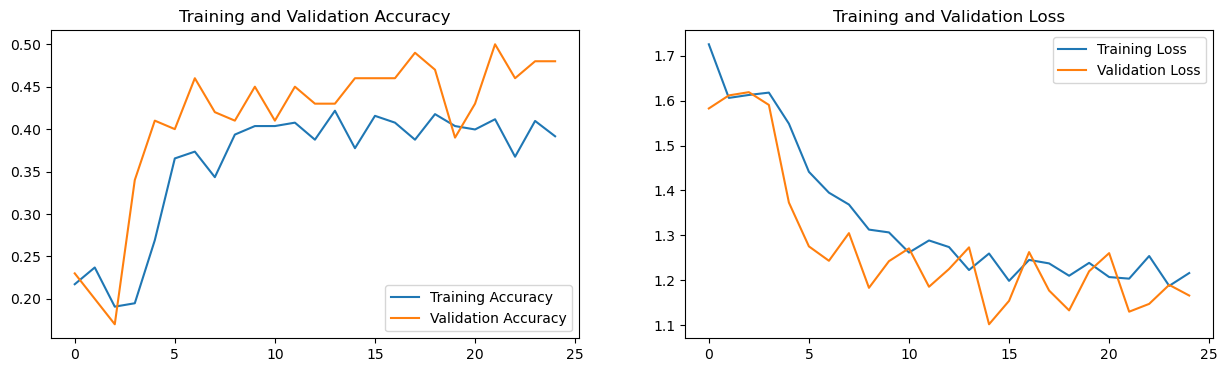

In [109]:
plot_history(history)

<b>Conclusion:</b> 
- Need to increase the number of epochs in a later experiment
- The model is underfitting with the current parameters

#### **Experiment 6**

Reducing the number of frames from 15 to 10

In [110]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
batch_size = 4
num_epochs=25

img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

##### **Model 6**
- 3D Convolutional Model with 3 layers of Conv3D and 3 layers of MaxPooling3D
- 2 Dense layers
- 2 Dropout layers
- 3 Batch Normalization layers
- 25 epochs
- Number of frames reduced to 10

In [111]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_36 (Ba  (None, 10, 50, 50, 8)     32        
 tchNormalization)                                               
                                                                 
 activation_36 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_36 (MaxPooli  (None, 5, 25, 25, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_37 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_37 (Ba  (None, 5, 25, 25, 16)   

In [112]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [113]:
model_name = 'model_exp6_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [114]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [115]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.8367 - categorical_accuracy: 0.1961Source path =  Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.60952, saving model to model_exp6_2024-02-0416_15_07.409691\model-00001-1.83665-0.19608-1.60952-0.18000.h5
166/166 [==============================] - 50s 293ms/step - loss: 1.8367 - categorical_accuracy: 0.1961 - val_loss: 1.6095 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.6106 - categorical_accuracy: 0.2169
Epoch 2: val_loss did not improve from 1.60952
166/166 [==============================] - 35s 209ms/step - loss: 1.6106 - categorical_accuracy: 0.2169 - val_loss: 1.6101 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/25
166/166 [==============================] - ETA: 0s - loss: 1.6098 - categorical_accuracy: 0.2048
Epoch 3: val_loss improved from 1.60952

**Training Accuracy:** 0.42%

**Validation Accuracy:** 0.61%

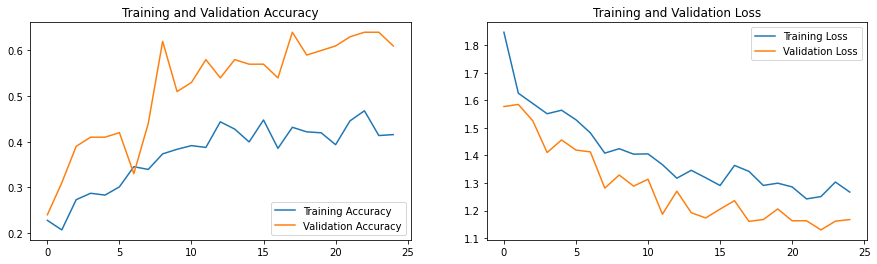

In [54]:
plot_history(history)

<b>Conclusion:</b> 
- The training and validation accuracy has increased after reducing the number of frames from 15 to 10
- The model is underfitting with the current parameters

#### **Experiment 7**

Reducing the dropout rate from 0.5 to 0.25

In [122]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
batch_size = 4
num_epochs=25
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

##### **Model 7**
- 3D Convolutional Model with 3 layers of Conv3D and 3 layers of MaxPooling3D
- 2 Dense layers
- 2 Dropout layers
- 3 Batch Normalization layers
- 25 epochs
- Dropout rate reduced to 0.25

In [123]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_42 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_42 (Ba  (None, 10, 50, 50, 8)     32        
 tchNormalization)                                               
                                                                 
 activation_42 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_42 (MaxPooli  (None, 5, 25, 25, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_43 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_43 (Ba  (None, 5, 25, 25, 16)   

In [124]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [125]:
model_name = 'model_exp7_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [126]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [127]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.6873 - categorical_accuracy: 0.2217Source path =  Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.61295, saving model to model_exp7_2024-02-0416_15_07.409691\model-00001-1.68729-0.22172-1.61295-0.21000.h5
166/166 [==============================] - 71s 422ms/step - loss: 1.6873 - categorical_accuracy: 0.2217 - val_loss: 1.6130 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.5272 - categorical_accuracy: 0.3353
Epoch 2: val_loss improved from 1.61295 to 1.46116, saving model to model_exp7_2024-02-0416_15_07.409691\model-00002-1.52718-0.33534-1.46116-0.27000.h5
166/166 [==============================] - 52s 317ms/step - loss: 1.5272 - categorical_accuracy: 0.3353 - val_loss: 1.4612 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/25
166/166 [======================

**Training Accuracy:** 0.78%

**Validation Accuracy:** 0.86%

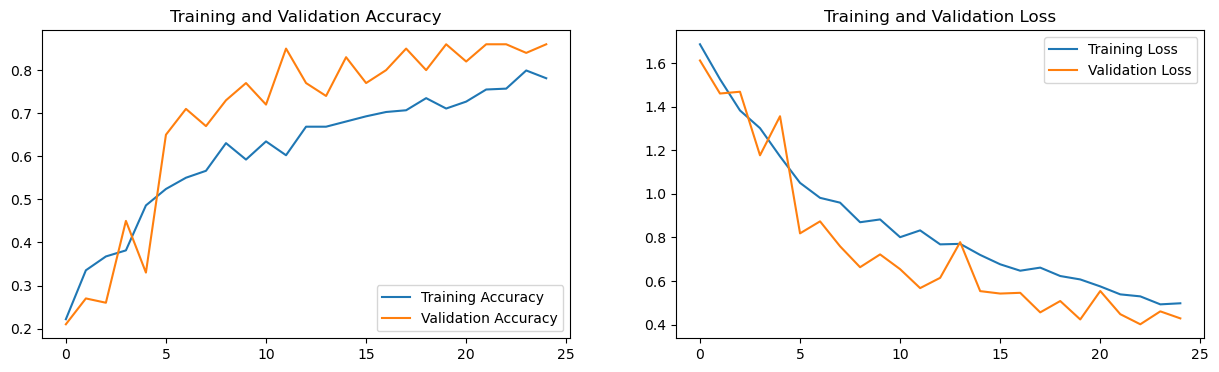

In [128]:
plot_history(history)

<b>Conclusion:</b> 
- A drop out rate of 0.25 gives up a better training and validation accuracy
- Model has resulted in better training and validation accuracy
- Model's performance has improved from the previous models
- Validation accuracy is better than the training accuracy

#### **Experiment 8**

Increasing the number of epochs from 25 to 35

In [129]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
batch_size = 4
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=35

##### **Model 8**
- 3D Convolutional Model with 3 layers of Conv3D and 3 layers of MaxPooling3D
- 2 Dense layers
- 2 Dropout layers
- 3 Batch Normalization layers
- 35 epochs

In [130]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_45 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_45 (Ba  (None, 10, 50, 50, 8)     32        
 tchNormalization)                                               
                                                                 
 activation_45 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_45 (MaxPooli  (None, 5, 25, 25, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_46 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_46 (Ba  (None, 5, 25, 25, 16)   

In [131]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [132]:
model_name = 'model_exp8_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [133]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [134]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 4
Epoch 1/35
166/166 [==============================] - ETA: 0s - loss: 1.7548 - categorical_accuracy: 0.2549Source path =  Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 2.07294, saving model to model_exp8_2024-02-0416_15_07.409691\model-00001-1.75479-0.25490-2.07294-0.25000.h5
166/166 [==============================] - 42s 249ms/step - loss: 1.7548 - categorical_accuracy: 0.2549 - val_loss: 2.0729 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/35
166/166 [==============================] - ETA: 0s - loss: 1.4459 - categorical_accuracy: 0.3514
Epoch 2: val_loss improved from 2.07294 to 1.31579, saving model to model_exp8_2024-02-0416_15_07.409691\model-00002-1.44591-0.35141-1.31579-0.40000.h5
166/166 [==============================] - 34s 205ms/step - loss: 1.4459 - categorical_accuracy: 0.3514 - val_loss: 1.3158 - val_categorical_accuracy: 0.4000 - lr: 0.0010
Epoch 3/35
166/166 [======================

**Training Accuracy:** 0.82%

**Validation Accuracy:** 0.82%

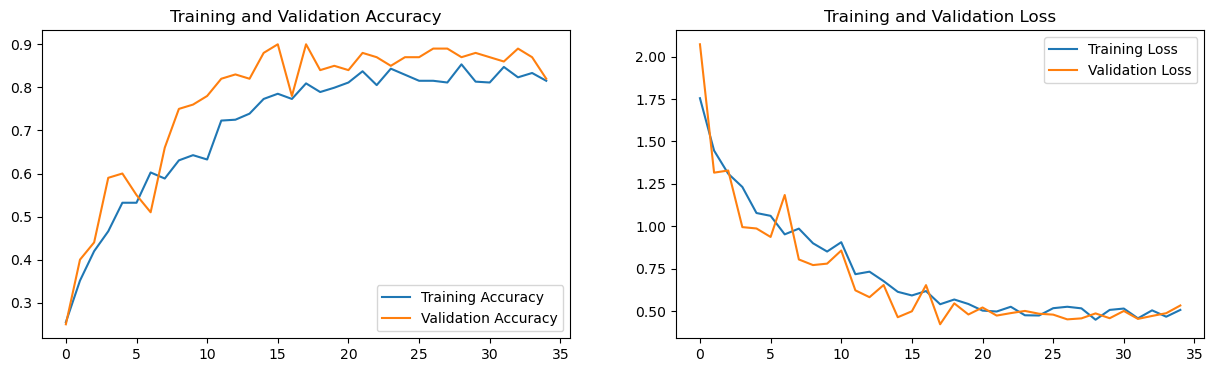

In [135]:
plot_history(history)

<b>Conclusion:</b> 
- After 35 epochs the training and validation accuracy changes to 82% and 82% respectively
- Good training and validation accuracy
- Model's performance has improved from the previous models
- Both training and validation accuracy are close to each other

## **CNN 2D + RNN Architecture**

#### **Experiment 9**
 Using CNN 2D + RNN architecture

In [241]:
# CNN2D + RNN

total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
batch_size = 4
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)


num_epochs=35

In [242]:
# Define the generator function for CNN2D + RNN
def generator_2d_rnn(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_crop_image(image)
                                         
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            
            for batch in range(batch_size): # we iterate over the number of batches
                batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size):
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                    for idx,item in enumerate(img_idx):
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                        image = resize_crop_image(image)
                                         
                        batch_data[folder,idx,:,:,0] = image[:,:,0]
                        batch_data[folder,idx,:,:,1] = image[:,:,1]
                        batch_data[folder,idx,:,:,2] = image[:,:,2]

                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels

In [243]:
train_generator = generator_2d_rnn(train_path, train_doc, batch_size)
val_generator = generator_2d_rnn(val_path, val_doc, batch_size)

##### **Model 9**
- 2D Convolutional Model with 3 layers of Conv2D and 3 layers of MaxPooling2D
- 2 GRU layers
- 2 Dense layers
- 2 Dropout layers
- 3 Batch Normalization layers

In [244]:
# CNN2D + RNN

model = Sequential()

model.add(TimeDistributed(Conv2D(8, (3, 3), padding='same'), input_shape=(len(img_idx), image_height, image_width, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=True))
model.add(Dropout(0.25))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.25))

model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_157 (Time  (None, 10, 50, 50, 8)     224       
 Distributed)                                                    
                                                                 
 activation_126 (Activation  (None, 10, 50, 50, 8)     0         
 )                                                               
                                                                 
 batch_normalization_126 (B  (None, 10, 50, 50, 8)     32        
 atchNormalization)                                              
                                                                 
 time_distributed_158 (Time  (None, 10, 25, 25, 8)     0         
 Distributed)                                                    
                                                                 
 time_distributed_159 (Time  (None, 10, 25, 25, 16)  

In [245]:
model_name = 'model_2d_rnn' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [246]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [247]:

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 4
Epoch 1/35
166/166 [==============================] - ETA: 0s - loss: 1.3229 - categorical_accuracy: 0.4495Source path =  Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.55713, saving model to model_2d_rnn2024-02-0416_15_07.409691\model-00001-1.32292-0.44947-1.55713-0.42000.h5
166/166 [==============================] - 77s 421ms/step - loss: 1.3229 - categorical_accuracy: 0.4495 - val_loss: 1.5571 - val_categorical_accuracy: 0.4200 - lr: 0.0010
Epoch 2/35
166/166 [==============================] - ETA: 0s - loss: 0.9579 - categorical_accuracy: 0.6245
Epoch 2: val_loss improved from 1.55713 to 1.05815, saving model to model_2d_rnn2024-02-0416_15_07.409691\model-00002-0.95786-0.62450-1.05815-0.58000.h5
166/166 [==============================] - 39s 237ms/step - loss: 0.9579 - categorical_accuracy: 0.6245 - val_loss: 1.0581 - val_categorical_accuracy: 0.5800 - lr: 0.0010
Epoch 3/35
166/166 [====================

**Training Accuracy:** 1.0%

**Validation Accuracy:** 0.79%

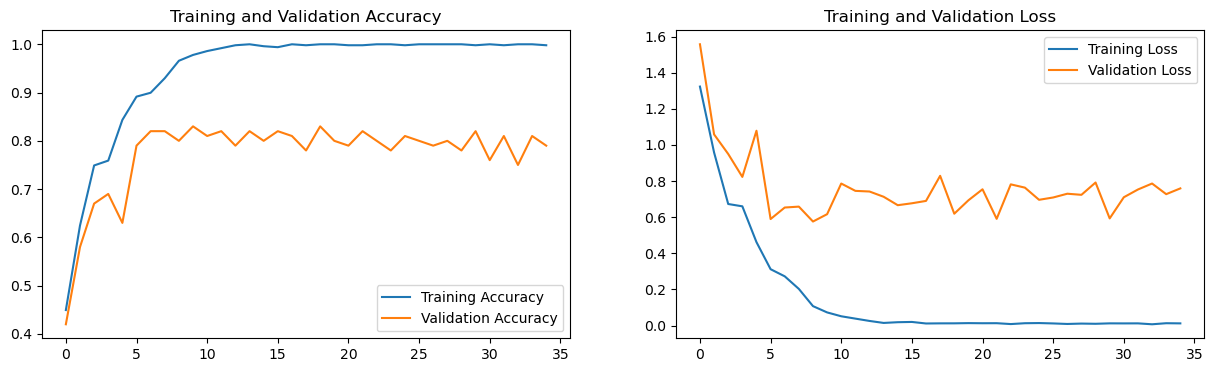

In [248]:
plot_history(history)

</b>Conclusion:</b>
- The model is underfitting with the current parameters
- Model has nearly 100% training accuracy and 80% validation accuracy

#### **Experiment 10**
Increase dropout rate from 0.25 to 0.5

##### **Model 10**
- 2D Convolutional Model with 3 layers of Conv2D and 3 layers of MaxPooling2D
- 2 GRU layers
- 2 Dense layers
- 2 Dropout layers
- 3 Batch Normalization layers
- Dropout rate increased to 0.5

In [254]:
# Overfitting - change the model to reduce overfitting

model = Sequential()

model.add(TimeDistributed(Conv2D(8, (3, 3), padding='same'), input_shape=(len(img_idx), image_height, image_width, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())


model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())


model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())


model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
          
model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=True))
model.add(Dropout(0.25))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.50))

model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_169 (Time  (None, 10, 50, 50, 8)     224       
 Distributed)                                                    
                                                                 
 activation_132 (Activation  (None, 10, 50, 50, 8)     0         
 )                                                               
                                                                 
 batch_normalization_132 (B  (None, 10, 50, 50, 8)     32        
 atchNormalization)                                              
                                                                 
 time_distributed_170 (Time  (None, 10, 50, 50, 16)    1168      
 Distributed)                                                    
                                                                 
 activation_133 (Activation  (None, 10, 50, 50, 16)  

In [255]:
model_name = 'model_2d_rnn_exp1' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [256]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [257]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/35
166/166 [==============================] - ETA: 0s - loss: 1.5961 - categorical_accuracy: 0.2811
Epoch 1: val_loss improved from inf to 1.36665, saving model to model_2d_rnn_exp12024-02-0416_15_07.409691\model-00001-1.59609-0.28112-1.36665-0.42000.h5
166/166 [==============================] - 117s 659ms/step - loss: 1.5961 - categorical_accuracy: 0.2811 - val_loss: 1.3667 - val_categorical_accuracy: 0.4200 - lr: 0.0010
Epoch 2/35
166/166 [==============================] - ETA: 0s - loss: 1.4215 - categorical_accuracy: 0.3755
Epoch 2: val_loss improved from 1.36665 to 1.26727, saving model to model_2d_rnn_exp12024-02-0416_15_07.409691\model-00002-1.42155-0.37550-1.26727-0.47000.h5
166/166 [==============================] - 103s 620ms/step - loss: 1.4215 - categorical_accuracy: 0.3755 - val_loss: 1.2673 - val_categorical_accuracy: 0.4700 - lr: 0.0010
Epoch 3/35
166/166 [==============================] - ETA: 0s - loss: 1.3028 - categorical_accuracy: 0.4659
Epoch 3: val_loss di

**Training Accuracy:** 0.89%

**Validation Accuracy:** 0.71%

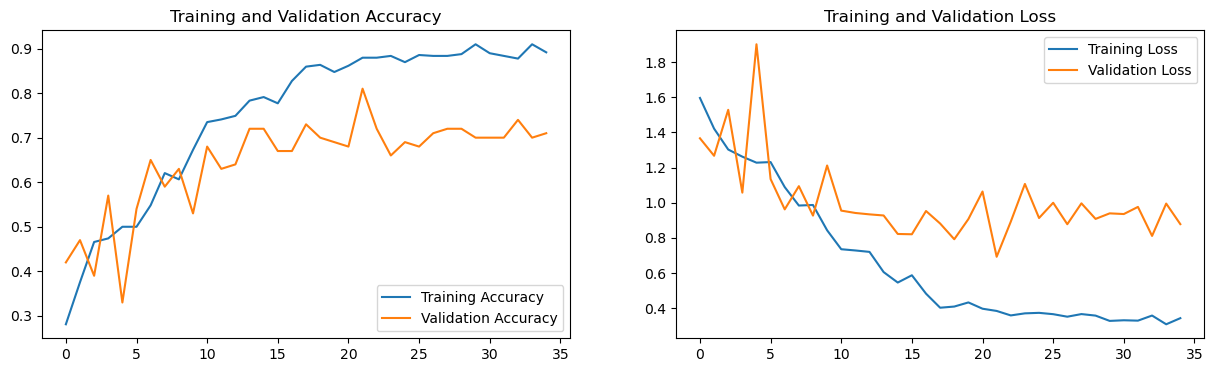

In [258]:
plot_history(history)

<b>Conclusion:</b>
- The model is overfitting with the current parameters
- Model has nearly 89% training accuracy and 71% validation accuracy

#### **Experiment 11**

Use CNN 2D + RNN architecture with LSTM layers

In [288]:
num_epochs=25

##### **Model 11**
- 2D Convolutional Model with 3 layers of Conv2D and 3 layers of MaxPooling2D
- 2 LSTM layers
- 2 Dense layers
- 2 Dropout layers
- 3 Batch Normalization layers
- 25 epochs

In [300]:
# CNN2D + RNN + LSTM with increased dropout

model = Sequential()

model.add(TimeDistributed(Conv2D(8, (3, 3), padding='same'), input_shape=(len(img_idx), image_height, image_width, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
   
model.add(TimeDistributed(Flatten()))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.25))

model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_297 (Time  (None, 10, 50, 50, 8)     224       
 Distributed)                                                    
                                                                 
 activation_188 (Activation  (None, 10, 50, 50, 8)     0         
 )                                                               
                                                                 
 batch_normalization_188 (B  (None, 10, 50, 50, 8)     32        
 atchNormalization)                                              
                                                                 
 time_distributed_298 (Time  (None, 10, 25, 25, 8)     0         
 Distributed)                                                    
                                                                 
 time_distributed_299 (Time  (None, 10, 25, 25, 16)  

In [301]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
166/166 [==============================] - ETA: 0s - loss: 1.4412 - categorical_accuracy: 0.3735
Epoch 1: val_loss did not improve from 0.45283
166/166 [==============================] - 90s 516ms/step - loss: 1.4412 - categorical_accuracy: 0.3735 - val_loss: 1.2516 - val_categorical_accuracy: 0.4800 - lr: 0.0010
Epoch 2/10
166/166 [==============================] - ETA: 0s - loss: 1.2518 - categorical_accuracy: 0.4940
Epoch 2: val_loss did not improve from 0.45283
166/166 [==============================] - 68s 411ms/step - loss: 1.2518 - categorical_accuracy: 0.4940 - val_loss: 1.0856 - val_categorical_accuracy: 0.6300 - lr: 0.0010
Epoch 3/10
166/166 [==============================] - ETA: 0s - loss: 1.0023 - categorical_accuracy: 0.6124
Epoch 3: val_loss did not improve from 0.45283
166/166 [==============================] - 63s 379ms/step - loss: 1.0023 - categorical_accuracy: 0.6124 - val_loss: 1.2250 - val_categorical_accuracy: 0.5300 - lr: 0.0010
Epoch 4/10
166/166 [==

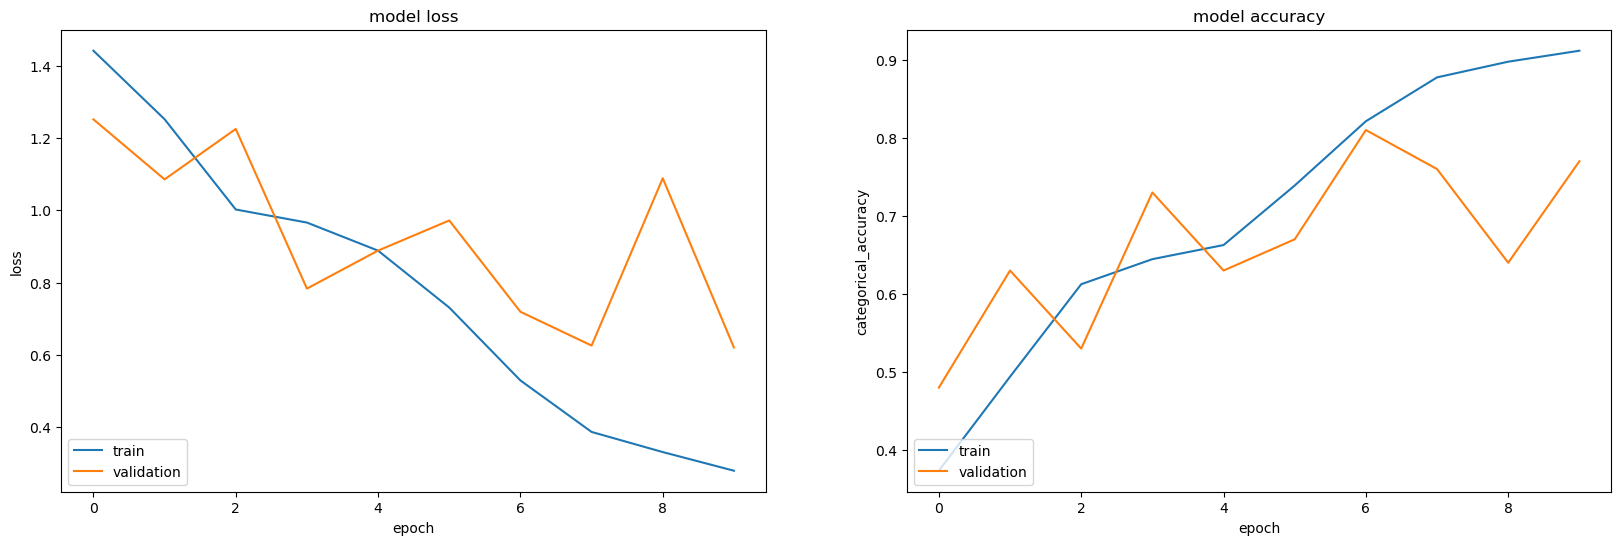

In [305]:
# plot the history of the model
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

<b> Conclusion:</b>
- The model is slightly overfitting with the current parameters
- Model has nearly 91% training accuracy and 77% validation accuracy

In [324]:
num_epochs=25

In [332]:
# Simple CNN2D + RNN + LSTM with removed convolutional layers

model = Sequential()

model.add(TimeDistributed(Conv2D(8, (3, 3), padding='same'), input_shape=(len(img_idx), image_height, image_width, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# add one more convolutional layer
model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# add one more convolutional layer
model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# use global average pooling instead of flatten
model.add(TimeDistributed(GlobalAveragePooling2D()))
#model.add(TimeDistributed(Flatten()))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.25))

model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())
          

Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_339 (Time  (None, 10, 50, 50, 8)     224       
 Distributed)                                                    
                                                                 
 activation_209 (Activation  (None, 10, 50, 50, 8)     0         
 )                                                               
                                                                 
 batch_normalization_209 (B  (None, 10, 50, 50, 8)     32        
 atchNormalization)                                              
                                                                 
 time_distributed_340 (Time  (None, 10, 25, 25, 8)     0         
 Distributed)                                                    
                                                                 
 time_distributed_341 (Time  (None, 10, 25, 25, 16)  

In [333]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.4670 - categorical_accuracy: 0.3313
Epoch 1: val_loss did not improve from 0.45283
166/166 [==============================] - 65s 363ms/step - loss: 1.4670 - categorical_accuracy: 0.3313 - val_loss: 1.5522 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.3673 - categorical_accuracy: 0.3976
Epoch 2: val_loss did not improve from 0.45283
166/166 [==============================] - 63s 380ms/step - loss: 1.3673 - categorical_accuracy: 0.3976 - val_loss: 1.5045 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 3/25
166/166 [==============================] - ETA: 0s - loss: 1.3593 - categorical_accuracy: 0.4116
Epoch 3: val_loss did not improve from 0.45283
166/166 [==============================] - 90s 548ms/step - loss: 1.3593 - categorical_accuracy: 0.4116 - val_loss: 1.3645 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 4/25
166/166 [==

**Training Accuracy:** 0.83%

**Validation Accuracy:** 0.71%

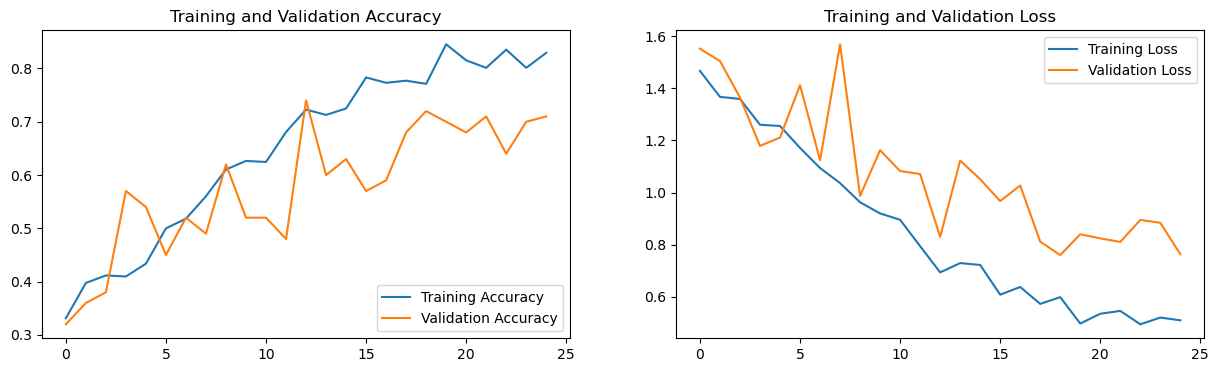

In [334]:
plot_history(history)

<b>Conclusion:</b>
- The model is better in terms of training and validation accuracy
- The model is not overfitting or underfitting
- The model has a good training and validation accuracy

## **Transfer Learning Architecture**

#### **Experiment 13**

Using Transfer Learning with MobileNetV2

##### **Model 13**
- MobileNetV2 with 2 Dense layers
- 2 Dropout layers
- 3 Batch Normalization layers
- 25 epochs

In [231]:
# Transfer Learning - MobileNet

from keras.applications import MobileNet

#write your model here
model = Sequential()

model.add(TimeDistributed(MobileNet(include_top=False, weights='imagenet', input_shape=(image_height, image_width, 3)), input_shape=(len(img_idx), image_height, image_width, 3)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.50))

model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

17225924/17225924 [==============================] - 2s 0us/step


Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_154 (Time  (None, 15, 3, 3, 1024)    3228864   
 Distributed)                                                    
                                                                 
 time_distributed_155 (Time  (None, 15, 1, 1, 1024)    0         
 Distributed)                                                    
                                                                 
 time_distributed_156 (Time  (None, 15, 1024)          0         
 Distributed)                                                    
                                                                 
 lstm_14 (LSTM)              (None, 64)                278784    
                                                                 
 dropout_109 (Dropout)       (None, 64)                0         
                                                     

In [232]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.4509 - categorical_accuracy: 0.3655
Epoch 1: val_loss did not improve from 0.75550
83/83 [==============================] - 93s 1s/step - loss: 1.4509 - categorical_accuracy: 0.3655 - val_loss: 1.1444 - val_categorical_accuracy: 0.4808 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.0545 - categorical_accuracy: 0.6225
Epoch 2: val_loss did not improve from 0.75550
83/83 [==============================] - 102s 1s/step - loss: 1.0545 - categorical_accuracy: 0.6225 - val_loss: 0.9550 - val_categorical_accuracy: 0.6923 - lr: 0.0010
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 0.9439 - categorical_accuracy: 0.6988
Epoch 3: val_loss improved from 0.75550 to 0.56953, saving model to model_2d_rnn2024-02-0416_15_07.409691\model-00003-0.94394-0.69880-0.56953-0.86538.h5


c:\Users\kriss\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - 130s 2s/step - loss: 0.9439 - categorical_accuracy: 0.6988 - val_loss: 0.5695 - val_categorical_accuracy: 0.8654 - lr: 0.0010
Epoch 4/25
83/83 [==============================] - ETA: 0s - loss: 0.8087 - categorical_accuracy: 0.7510
Epoch 4: val_loss did not improve from 0.56953
83/83 [==============================] - 138s 2s/step - loss: 0.8087 - categorical_accuracy: 0.7510 - val_loss: 0.7249 - val_categorical_accuracy: 0.7692 - lr: 0.0010
Epoch 5/25
83/83 [==============================] - ETA: 0s - loss: 0.7147 - categorical_accuracy: 0.7751
Epoch 5: val_loss did not improve from 0.56953

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
83/83 [==============================] - 124s 2s/step - loss: 0.7147 - categorical_accuracy: 0.7751 - val_loss: 0.7288 - val_categorical_accuracy: 0.7885 - lr: 0.0010
Epoch 6/25
83/83 [==============================] - ETA: 0s - loss: 0.6793 - categorical_accuracy: 0.7952
Epoch 6: v

**Training Accuracy:** 0.96%

**Validation Accuracy:** 0.96%

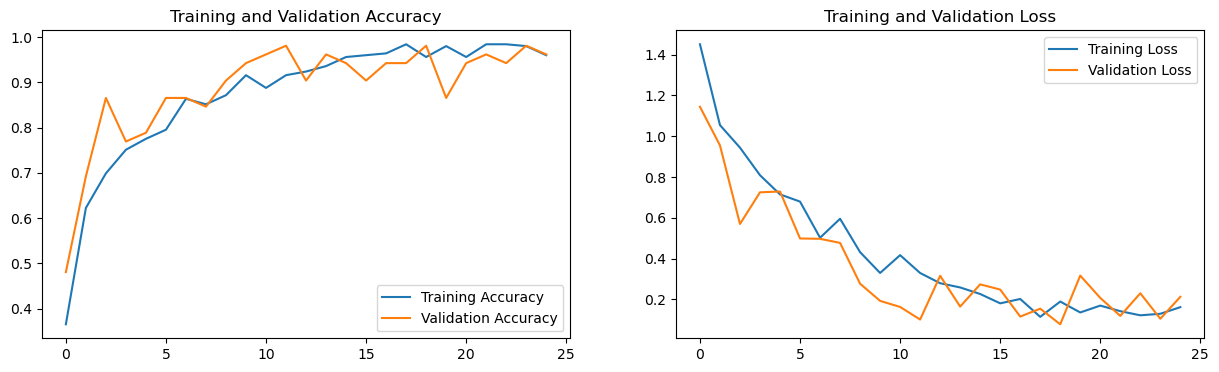

In [233]:
plot_history(history)

<b>Conclusion:</b> 
- After 35 epochs the training and validation accuracy values are almost same - 96%
- Best model compared to the previous models
- Model's performance has improved from the previous models